# **Procesamiento de imagenes**

# **Unsupervised Clustering**

## **¿Qué haremos en este notebook?** <br>
En este notebook, daremos a la computadora un grupo de imágenes de pokemones y que pueda agrupar a las que tienen las mismos caracteristicas.

Se hara codificando las imágenes a través de una red convolucional entrenada y luego aplicaremos un algoritmo de clustering a las features codificadas. despues vamos a verificar los grupos y ver los resultados

In [1]:
import time
import os, os.path
import random
import cv2
import glob
import keras
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

import pandas as pd
import numpy as np


## 1. Cargar el dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')
# link del dataset:
# https://drive.google.com/drive/folders/1aq-Cv20rnPKU_WWjSskSqdoqKyBUBoMI?usp=sharing
# Deben descargar el dataset y subirlo a su drive

Mounted at /content/drive


In [3]:
ls

drive/  sample_data/


In [4]:
cd /content/drive/MyDrive/ML_I-2022/2do parcial/
# Deben buscar la rut de donde guardaron el dataset 

/content/drive/MyDrive/ML_I-2022/2do parcial


In [5]:
ls

 dataset/  'dimensionality reduction'/  'procesamiento_de _img.ipynb'


In [6]:
# directorio donde se almacenan las imágenes
DIR = "./dataset"

def dataset_stats():
    # Esta es una matriz con las letras disponibles.
    # Si agrega otro animal más tarde, necesitará estructurar sus imágenes de la misma manera
    # y agrega su letra a esta matriz
    pokemon_characters = ['Bulbasaur', 'Charmendar', 'Pikachu']
   
    # stats sera el diccionario donde almacenaremos las estadísticas
    stats = []
    
    for pokemon in pokemon_characters:
        # obtenemos una lista de subdirectorios que comienzan con este caracter
        directory_list = sorted(glob.glob("{}/[{}]*".format(DIR, pokemon)))
        
        for sub_directory in directory_list:
            file_names = [file for file in os.listdir(sub_directory)]
            file_count = len(file_names)
            sub_directory_name = os.path.basename(sub_directory)
            stats.append({  "Code": sub_directory_name, #"Code": sub_directory_name[:sub_directory_name.find('-')],
                            "Image count": file_count, 
                            "Folder name": os.path.basename(sub_directory),
                            "File names": file_names})
    
    df = pd.DataFrame(stats)
    
    return df

## 2. Exploracion y preprocesamiento del dataset


In [7]:
# Mostrar códigos con sus nombres de las carpetas y la cantidad de imágenes
dataset = dataset_stats().set_index("Code")
dataset[["Folder name", "Image count"]]

,Folder name,Image count
Code,,
Bulbasaur,Bulbasaur,142
Charmendar,Charmendar,142
Pikachu,Pikachu,142


In [ ]:
dataset

,Image count,Folder name,File names
Code,,,
Bulbasaur,142,Bulbasaur,"[1100.jpg, 1101.jpg, 1131.jpg, 1115.jpg, 1121...."
Charmendar,142,Charmendar,"[2200.jpg, 2201.jpg, 2202.jpg, 2203.jpg, 2210...."
Pikachu,142,Pikachu,"[2005.jpg, 2007.jpg, 2019.jpg, 2004.jpg, 2009...."


# **Cargando las imágenes**
Ahora creamos una función que carga todas las imágenes en un directorio y una matriz de etiquetas correspondiente para ellos.

Las imágenes cargadas se redimensionan a 224 x 224 antes de almacenarlas en nuestra matriz, ya que este es el tamaño preferido por VGG16 que usaremos más adelante.

In [9]:
# La función devuelve un conjunto de imágenes cuyos nombres de archivo comienzan con el conjunto de caracteres dado
# después de cambiar su tamaño a 224 x 224

def load_images(codes):
    
    # Definimos matrices vacías donde almacenaremos nuestras imágenes y etiquetas
    images = []
    labels = []
    
    for code in codes:
        # obtenemos el nombre de la carpeta para este código
        folder_name = dataset.loc[code]["Folder name"]
        
        for file in dataset.loc[code]["File names"]:                 
            # construimos la ruta del arichivo
            file_path = os.path.join(DIR, folder_name, file)
            
            # Leemos la imagen
            image = cv2.imread(file_path)
            
            # Cambiamos el tamaño a 224 x 224
            image = cv2.resize(image, (224,224))
            
            # Convertimos de BGR a RGB para que podamos trazarlos más tarde (porque openCV lee las imágenes como BGR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Ahora lo agregamos a nuestra matriz
            images.append(image)
            labels.append(code)

    return images, labels

In [10]:
codes = ["Bulbasaur", "Charmendar", "Pikachu"]
images, labels = load_images(codes)

In [23]:
#labels
#images

In [16]:
def show_random_images(images, labels, number_of_images_to_show=2):

    for code in list(set(labels)):

        indicies = [i for i, label in enumerate(labels) if label == code]
        random_indicies = [random.choice(indicies) for i in range(number_of_images_to_show)]
        figure, axis = plt.subplots(1, number_of_images_to_show)

        print("{} random images for code {}".format(number_of_images_to_show, code))

        for image in range(number_of_images_to_show):
            axis[image].imshow(images[random_indicies[image]])
        plt.show()

2 random images for code Bulbasaur


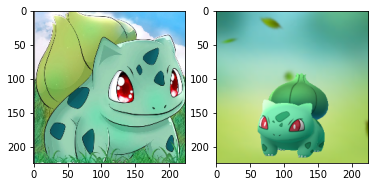

2 random images for code Pikachu


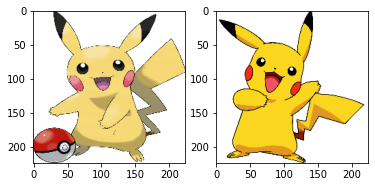

2 random images for code Charmendar


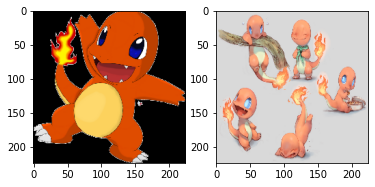

In [21]:
show_random_images(images, labels)

In [24]:
def normalise_images(images, labels):
   
    # Convertimos en arreglos para Numpy
    images = np.array(images, dtype=np.float32) 
    labels = np.array(labels)
    
    # Normalizamos las imágenes
    images /= 255
    
    return images, labels

In [25]:
images, labels = normalise_images(images, labels)

In [27]:
labels

array(['Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur',
       'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur',
       'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur',
       'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur',
       'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur',
       'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur',
       'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur',
       'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur',
       'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur',
       'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur',
       'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur',
       'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur',
       'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur',
       'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulbasaur', 'Bulb

## 3. Entrenamiento del modelo

In [28]:
def shuffle_data(images, labels):

    # Pondremos a un lado el conjunto de prueba 
    # No los tocaremos hasta el final.
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=1, random_state=728)
    
    return X_train, y_train

In [29]:
# division del conjunto de datos
X_train, y_train = shuffle_data(images, labels)

In [30]:
!sudo pip3 install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
import keras 
from keras.applications import vgg16 
vgg16_model = keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224,224,3))

58900480/58889256 [==============================] - 1s 0us/step


# **VGG16** 
Es una arquitectura de red neuronal de convolución (**CNN**) <br>
El 16 en **VGG16** se refiere a que tiene 16 capas que tienen pesos. Esta red es bastante grande y tiene alrededor de 138 millones (aprox.) de parámetros. <br>
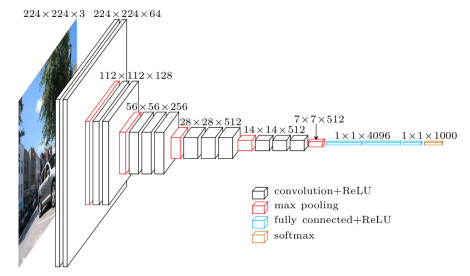

In [32]:
# se usara una red preentrenada como parte del preprocesamiento
def covnet_transform(covnet_model, raw_images):

    # Pasamos nuestros datos de entrenamiento a través de la red   
    pred = covnet_model.predict(raw_images)
    
    # aplanamos la matriz
    flat = pred.reshape(raw_images.shape[0], -1)
    
    return flat

In [33]:
vgg16_output = covnet_transform(vgg16_model, X_train)
print("VGG16 flattened output has {} features".format(vgg16_output.shape[1]))

VGG16 flattened output has 25088 features


La celda de arriba nos muestra la cantidad de características que covnet le da a cada a una de las imagen. Cuando los comparamos con el tamaño original de la imagen 224 x 224 x 3 = 150528 píxeles/características, podemos ver que se trata de una gran reducción en lo que se tendrán que trabajar en algoritmos de agrupamiento.

Esperemos que estos números reducidos de características representen características más significativas en la estructura de la imagen.

# **PCA**
Si bien el agrupamiento de k-means ha hecho frente a estos números, pero el modelo de Gaussian Mixture.

Por lo tanto, aplicaremos PCA para la reducción de la dimensiones, de modo que nuestros algoritmos de agrupamiento puedan hacer frente.

In [34]:
# Función que crea una instancia de PCA, la ajusta a los datos y devuelve la instancia
def create_fit_PCA(data, n_components=None):
    
    p = PCA(n_components=n_components, random_state=728)
    p.fit(data)
    
    return p

In [35]:
# Crear la instancias de PCA para cada salida de covnet
vgg16_pca = create_fit_PCA(vgg16_output)

In [36]:
# Función para trazar la varianza explicativa acumulativa de los componentes de PCA
# Esto nos ayudará a decidir cuántos componentes debemos reducir en nuestras funciones
def pca_cumsum_plot(pca):
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.show()

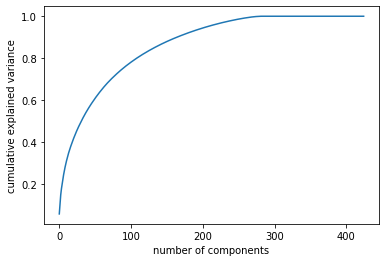

In [37]:
# Trazamos la varianza explicativa acumulativa para cada covnet
pca_cumsum_plot(vgg16_pca)

In [38]:
# Transformamos PCA para las salidas de covnet
vgg16_output_pca = vgg16_pca.transform(vgg16_output)

### 3.1. Comparar diferentes modelo

# **Cluster** 
Vamos a ver un par de funciones que crearan y se ajustarían a los modelos KMeans y Gaussian Mixture.


1.   **KMeans** <br>
El algoritmo utiliza una proceso iterativo en el que se van ajustando los grupos para producir el resultado final.
2.   **Gaussian Mixture Models** <br>
Se asumen que hay un cierto número de distribuciones gaussianas, y cada una de estas distribuciones representa un grupo. Por lo tanto, un modelo de mezcla gaussiana tiende a agrupar los puntos de datos que pertenecen a una sola distribución.



In [39]:
def create_train_kmeans(data, number_of_clusters=len(codes)):
    k = KMeans(n_clusters=number_of_clusters, random_state=728)

    # Haremos algunos horarios para ver cuánto tiempo lleva entrenar.
    start = time.time()

    # Entrenarlo
    k.fit(data)

    # Detener el tiempo
    end = time.time()

    # Y miramos cuánto tiempo nos tomó esto
    print("Training took {} seconds".format(end-start))
    
    return k

In [40]:
def create_train_gmm(data, number_of_clusters=len(codes)):
    g = GaussianMixture(n_components=number_of_clusters, covariance_type="full", random_state=728)
    
    start=time.time()
    g.fit(data)
    end=time.time()
    
    print("Training took {} seconds".format(end-start))
    
    return g

In [41]:
# Pasemos los datos al algoritmo y las predicciones de quién se encuentra en qué grupo.
# Dado que estamos utilizando los mismos datos en los que entrenamos, esto debería darnos los resultados del entrenamiento.

# Aquí creamos y ajustamos un modelo KMeans con la salida PCA
print("KMeans (PCA): \n")

print("VGG16")
K_vgg16_pca = create_train_kmeans(vgg16_output_pca)

KMeans (PCA): 

VGG16
Training took 0.16611838340759277 seconds


In [42]:
# Lo mismo para el modelo gaussiano
print("GMM (PCA): \n")

print("VGG16")
G_vgg16_pca = create_train_gmm(vgg16_output_pca)

GMM (PCA): 

VGG16
Training took 0.509225606918335 seconds


In [43]:
# También creemos modelos para las salidas covnet sin PCA para comparar
print("KMeans: \n")

print("VGG16:")
K_vgg16 = create_train_kmeans(vgg16_output)

KMeans: 

VGG16:
Training took 3.9095401763916016 seconds


In [44]:
# Ahora tenemos las predicciones del modelo cluster

# KMeans con salidas PCA
k_vgg16_pred_pca = K_vgg16_pca.predict(vgg16_output_pca)

# KMeans con salidas CovNet
k_vgg16_pred = K_vgg16.predict(vgg16_output)

# Gaussian Mixture con salidas PCA
g_vgg16_pred_pca = G_vgg16_pca.predict(vgg16_output_pca)

Recuerde que el algoritmo de agrupamiento no detecta qué imágenes son Bulbasaur, Charmendar y Pikachu, solo agrupa las imágenes que se parecen y les asigna un número arbitrariamente.

Ahora necesitamos contar cuántos hay de cada etiqueta por cada grupo, de esta manera podemos.

In [45]:
def cluster_label_count(clusters, labels):
    
    count = {}

    # Obtengamos los clústeres y las etiquetas
    unique_clusters = list(set(clusters))
    unique_labels = list(set(labels))
    
    # Creamos un contador para cada combinación del clúster sobre(/) etiqueta y establecerlo en 0
    for cluster in unique_clusters:
        count[cluster] = {}
        
        for label in unique_labels:
            count[cluster][label] = 0
    
    # Contemos
    for i in range(len(clusters)):
        count[clusters[i]][labels[i]] +=1
    
    cluster_df = pd.DataFrame(count)
    
    return cluster_df

In [46]:
# Recuentamos los clústeres para medios VGG16
vgg16_cluster_count = cluster_label_count(k_vgg16_pred, y_train)
vgg16_cluster_count_pca = cluster_label_count(k_vgg16_pred_pca, y_train)

# GMM
g_vgg16_cluster_count_pca = cluster_label_count(g_vgg16_pred_pca, y_train)

In [47]:
print("KMeans VGG16: ")
vgg16_cluster_count

KMeans VGG16: 


,0,1,2
Bulbasaur,87,3,52
Pikachu,0,0,142
Charmendar,0,102,39


In [48]:
print("KMeans VGG16 (PCA): ")
vgg16_cluster_count_pca

KMeans VGG16 (PCA): 


,0,1,2
Bulbasaur,87,3,52
Pikachu,0,0,142
Charmendar,0,102,39


In [49]:
print("GMM VGG16: ")
g_vgg16_cluster_count_pca

GMM VGG16: 


,0,1,2
Bulbasaur,0,0,142
Pikachu,0,95,47
Charmendar,77,10,54


In [56]:
# Ajustamos manualmente estas listas para que el índice de cada etiqueta refleje en qué cluster se encuentra
vgg16_cluster_code = ["Bulbasaur", "Charmendar", "Pikachu"]
vgg16_cluster_code_pca = ["Bulbasaur", "Charmendar", "Pikachu"]


In [57]:
vgg16_pred_codes = [vgg16_cluster_code[x] for x in k_vgg16_pred]
vgg16_pred_codes_pca = [vgg16_cluster_code_pca[x] for x in k_vgg16_pred_pca]


# **Métrica**
Ahora que tenemos dos matrices, una con las etiquetas predichas y otra con las etiquetas verdaderas, podemos volvernos locos con las puntuaciones de rendimiento... o simplemente podemos calcular la puntuación F1

In [58]:
from sklearn.metrics import accuracy_score, f1_score

def print_scores(true, pred):
    acc = accuracy_score(true, pred)
    f1 = f1_score(true, pred, average="macro")
    return "\n\tF1 Score: {0:0.8f}   |   Accuracy: {0:0.8f}".format(f1,acc)

print("KMeans VGG16:", print_scores(y_train, vgg16_pred_codes))
print("KMeans VGG16 (PCA)", print_scores(y_train, vgg16_pred_codes_pca))


KMeans VGG16: 
	F1 Score: 0.78214232   |   Accuracy: 0.78214232
KMeans VGG16 (PCA) 
	F1 Score: 0.78214232   |   Accuracy: 0.78214232
